In [1]:
reset -f

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading the datasets
df = pd.read_csv("training_set_VU_DM.csv", index_col=0)
df_test = pd.read_csv("test_set_VU_DM.csv", index_col=0)

# Log transformation for 'price_usd'
df['log_price_usd'] = np.log1p(df['price_usd'])
df_test['log_price_usd'] = np.log1p(df_test['price_usd'])

In [3]:
# # Analysis plots
# plt.hist(df['log_price_usd'], bins=50)
# plt.title('Distribution of log_price_usd')
# plt.show()
#
# plt.scatter(df['srch_length_of_stay'], df['log_price_usd'])
# plt.title('log_price_usd vs Length of Stay')
# plt.xlabel('Length of Stay')
# plt.ylabel('Log Price USD')
# plt.show()
#
# plt.scatter(df['srch_booking_window'], df['log_price_usd'])
# plt.title('log_price_usd vs Booking Window')
# plt.xlabel('Booking Window')
# plt.ylabel('Log Price USD')
# plt.show()

In [4]:
# # Calculating averages
# grouped = df.groupby('srch_length_of_stay')['log_price_usd'].mean()
# plt.plot(grouped)
# plt.title('Average log_price_usd by Length of Stay')
# plt.xlabel('Length of Stay')
# plt.ylabel('Average Log Price USD')
# plt.show()
#
# plt.scatter(df['prop_log_historical_price'], df['log_price_usd'])
# plt.title('log_price_usd vs Log Historical Price')
# plt.xlabel('Log Historical Price')
# plt.ylabel('Log Price USD')
# plt.show()
#
# grouped = df.groupby('prop_log_historical_price')['log_price_usd'].mean()
# plt.plot(grouped)
# plt.title('Average log_price_usd by Log Historical Price')
# plt.xlabel('Log Historical Price')
# plt.ylabel('Average Log Price USD')
# plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Date processing and creating CSV
df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month
df_test['date_time'] = pd.to_datetime(df_test['date_time'])
df_test['month'] = df_test['date_time'].dt.month

df['prop_historical_price'] = np.exp(df['prop_log_historical_price'])
df_test['prop_historical_price'] = np.exp(df_test['prop_log_historical_price'])

property_price_range = df.groupby(['prop_id', 'month'])['price_usd'].agg(['min', 'max']).reset_index()
property_price_range.rename(columns={'min': 'min_price', 'max': 'max_price'}, inplace=True)
property_price_range_test = df_test.groupby(['prop_id', 'month'])['price_usd'].agg(['min', 'max']).reset_index()
property_price_range_test.rename(columns={'min': 'min_price', 'max': 'max_price'}, inplace=True)

property_length_of_stay = df.groupby(['prop_id', 'month'])['srch_length_of_stay'].agg(['min', 'max']).reset_index()
property_length_of_stay.rename(columns={'min': 'min_length_of_stay', 'max': 'max_length_of_stay'}, inplace=True)
property_length_of_stay_test = df_test.groupby(['prop_id', 'month'])['srch_length_of_stay'].agg(['min', 'max']).reset_index()
property_length_of_stay_test.rename(columns={'min': 'min_length_of_stay', 'max': 'max_length_of_stay'}, inplace=True)

property_info = pd.merge(property_price_range, property_length_of_stay, on=['prop_id', 'month'])
additional_info = df[['prop_id', 'month', 'site_id', 'prop_historical_price', 'visitor_hist_adr_usd', 'price_usd']].drop_duplicates()
property_info = pd.merge(property_info, additional_info, on=['prop_id', 'month'])
property_info_test = pd.merge(property_price_range_test, property_length_of_stay_test, on=['prop_id', 'month'])
additional_info_test = df_test[['prop_id', 'month', 'site_id', 'prop_historical_price', 'visitor_hist_adr_usd', 'price_usd']].drop_duplicates()
property_info_test = pd.merge(property_info_test, additional_info_test, on=['prop_id', 'month'])

conditions = [(property_info['min_price'] / property_info['min_length_of_stay'] * property_info['max_length_of_stay']) > property_info['max_price'],
              property_info['min_length_of_stay'] == property_info['max_length_of_stay']]
conditions_test = [(property_info_test['min_price'] / property_info_test['min_length_of_stay'] * property_info_test['max_length_of_stay']) > property_info_test['max_price'],
              property_info_test['min_length_of_stay'] == property_info_test['max_length_of_stay']]

choices = [1, 0]
choices_test = [1, 0]

property_info['price_per_night'] = np.select(conditions, choices, default=0)
property_info_test['price_per_night'] = np.select(conditions_test, choices_test, default=0)

conditions = [property_info['price_per_night'] == 1,
              property_info['price_per_night'] == 0]
conditions_test = [property_info_test['price_per_night'] == 1,
              property_info_test['price_per_night'] == 0]

choices = [(property_info['min_price'] + property_info['max_price']) / 2,
           ((property_info['min_price'] / property_info['min_length_of_stay']) + (property_info['max_price'] / property_info['max_length_of_stay'])) / 2]
choices_test = [(property_info_test['min_price'] + property_info_test['max_price']) / 2,
           ((property_info_test['min_price'] / property_info_test['min_length_of_stay']) + (property_info_test['max_price'] / property_info_test['max_length_of_stay'])) / 2]

property_info['avg_price'] = np.select(conditions, choices)
property_info['log_avg_price'] = np.log1p(property_info['avg_price'])
property_info_test['avg_price'] = np.select(conditions_test, choices_test)
property_info_test['log_avg_price'] = np.log1p(property_info_test['avg_price'])

property_info.to_csv('property_info.csv', index=False)
property_info_test.to_csv('property_info_test.csv', index=False)

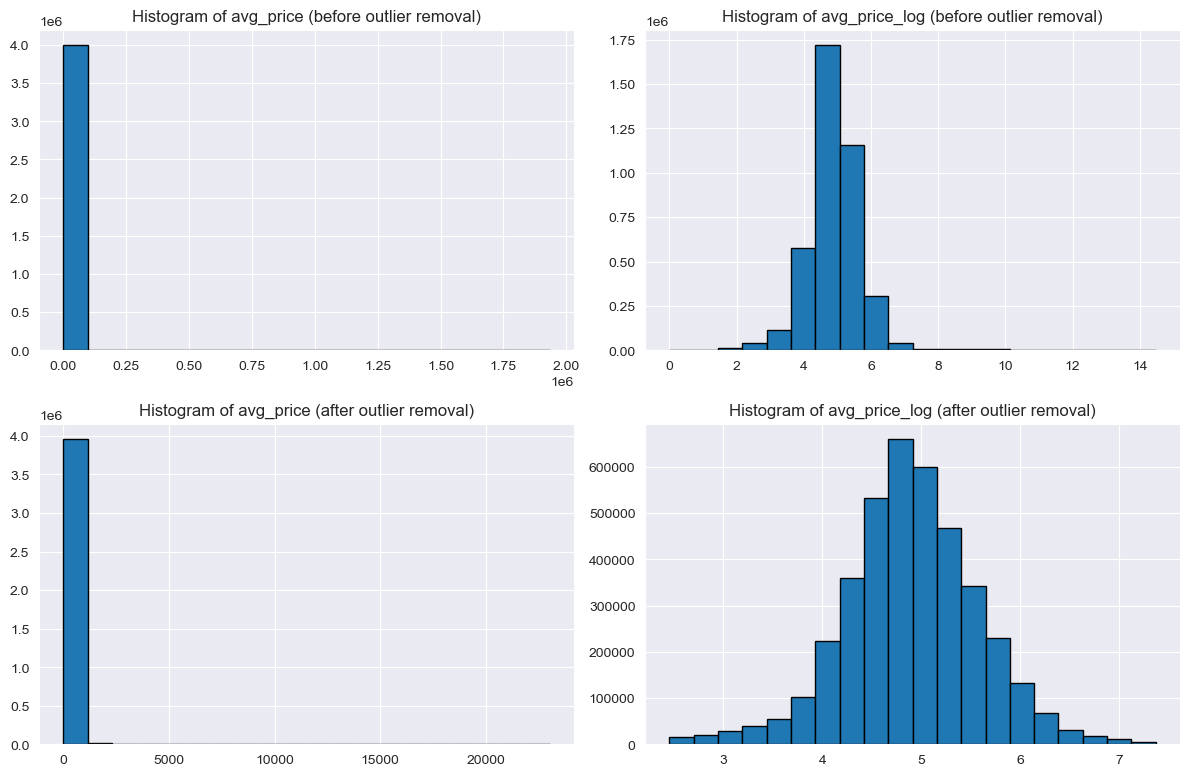

In [6]:
from scipy.stats import zscore

# Checking for outliers in avg_price and whether to use avg_price or log_avg_price
property_info['avg_price_log'] = np.log1p(property_info['avg_price'])
z_scores_before = zscore(property_info['avg_price'])
z_scores_after = zscore(property_info['avg_price_log'])

outliers_before = property_info[np.abs(z_scores_before) > 3]
outliers_after = property_info[np.abs(z_scores_after) > 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(property_info['avg_price'], bins=20, edgecolor='black')
axs[0, 0].set_title('Histogram of avg_price (before outlier removal)')
axs[0, 1].hist(property_info['avg_price_log'], bins=20, edgecolor='black')
axs[0, 1].set_title('Histogram of avg_price_log (before outlier removal)')

property_info_no_outliers_before = property_info.loc[~property_info.index.isin(outliers_before.index)]
property_info_no_outliers_after = property_info.loc[~property_info.index.isin(outliers_after.index)]

axs[1, 0].hist(property_info_no_outliers_before['avg_price'], bins=20, edgecolor='black')
axs[1, 0].set_title('Histogram of avg_price (after outlier removal)')
axs[1, 1].hist(property_info_no_outliers_after['avg_price_log'], bins=20, edgecolor='black')
axs[1, 1].set_title('Histogram of avg_price_log (after outlier removal)')

plt.tight_layout()
plt.show()


## Doing the same for the testdata

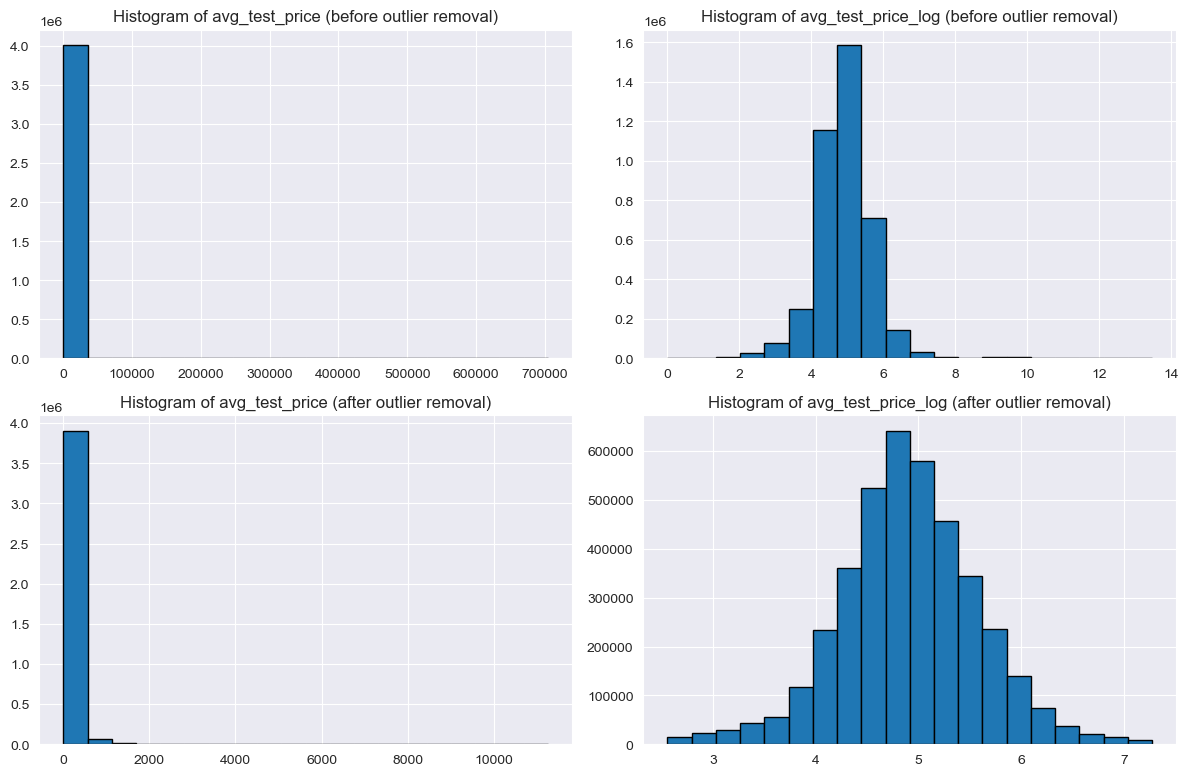

In [7]:
from scipy.stats import zscore

# Checking for outliers in avg_price and whether to use avg_price or log_avg_price
property_info_test['avg_price_log'] = np.log1p(property_info_test['avg_price'])
z_scores_before_test = zscore(property_info_test['avg_price'])
z_scores_after_test = zscore(property_info_test['avg_price_log'])

outliers_before_test = property_info_test[np.abs(z_scores_before_test) > 3]
outliers_after_test = property_info_test[np.abs(z_scores_after_test) > 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(property_info_test['avg_price'], bins=20, edgecolor='black')
axs[0, 0].set_title('Histogram of avg_test_price (before outlier removal)')
axs[0, 1].hist(property_info_test['avg_price_log'], bins=20, edgecolor='black')
axs[0, 1].set_title('Histogram of avg_test_price_log (before outlier removal)')

property_info_no_outliers_before_test = property_info_test.loc[~property_info_test.index.isin(outliers_before_test.index)]
property_info_no_outliers_after_test = property_info_test.loc[~property_info_test.index.isin(outliers_after_test.index)]

axs[1, 0].hist(property_info_no_outliers_before_test['avg_price'], bins=20, edgecolor='black')
axs[1, 0].set_title('Histogram of avg_test_price (after outlier removal)')
axs[1, 1].hist(property_info_no_outliers_after_test['avg_price_log'], bins=20, edgecolor='black')
axs[1, 1].set_title('Histogram of avg_test_price_log (after outlier removal)')

plt.tight_layout()
plt.show()


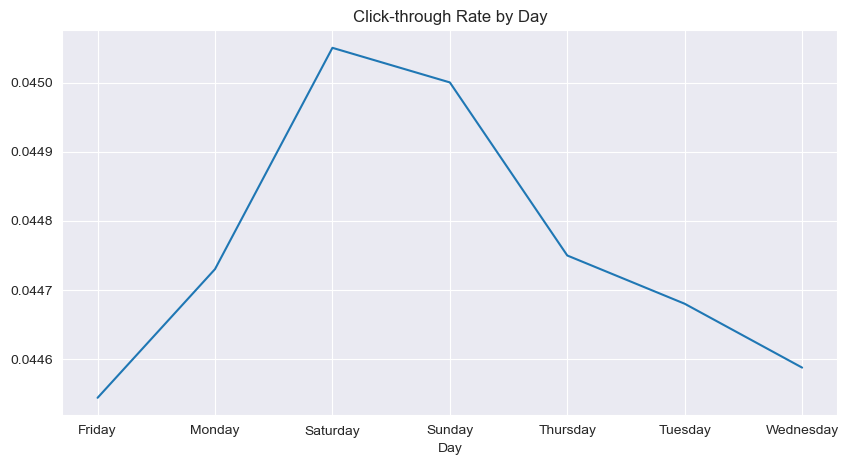

In [8]:
# Break down date to more features - year - month - day - hour
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_string'] = df['date_time'].dt.day_name()

click_rate_by_hour = df.groupby('day_string')['click_bool'].mean()
click_rate_by_hour.plot(kind='line', figsize=(10, 5))
plt.title("Click-through Rate by Day")
plt.xlabel("Day")
plt.show()

## Doing the same for test data

                  date_time  site_id  visitor_location_country_id  \
srch_id                                                             
1       2013-02-02 15:27:40       24                          216   
1       2013-02-02 15:27:40       24                          216   
1       2013-02-02 15:27:40       24                          216   
1       2013-02-02 15:27:40       24                          216   
1       2013-02-02 15:27:40       24                          216   
...                     ...      ...                          ...   
332787  2013-05-21 11:06:37       24                          216   
332787  2013-05-21 11:06:37       24                          216   
332787  2013-05-21 11:06:37       24                          216   
332787  2013-05-21 11:06:37       24                          216   
332787  2013-05-21 11:06:37       24                          216   

         visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
srch_id                    

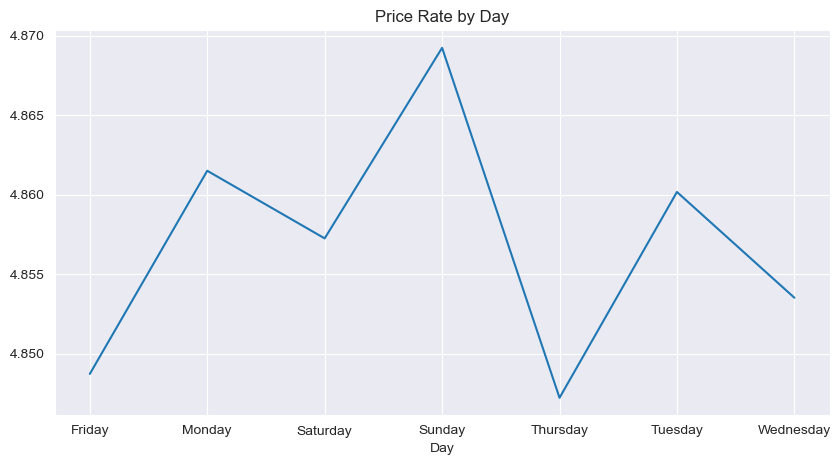

In [9]:
# Break down date to more features - year - month - day - hour
df_test['date_time'] = pd.to_datetime(df_test['date_time'])
df_test['year'] = df_test['date_time'].dt.year
df_test['month'] = df_test['date_time'].dt.month
df_test['day'] = df_test['date_time'].dt.day
df_test['hour'] = df_test['date_time'].dt.hour
df_test['day_string'] = df_test['date_time'].dt.day_name()

print(df_test)

price_rate_by_hour_test = df_test.groupby('day_string')['log_price_usd'].mean()
price_rate_by_hour_test.plot(kind='line', figsize=(10, 5))
plt.title("Price Rate by Day")
plt.xlabel("Day")
plt.show()

In [10]:
# # Convert competitor info to aggregated_info
# rate_cols = [f'comp{i}_rate' for i in range(1, 9)]
# inv_cols = [f'comp{i}_inv' for i in range(1, 9)]
# percent_diff_cols = [f'comp{i}_rate_percent_diff' for i in range(1, 9)]
#
# df['avg_rate'] = df[rate_cols].mean(axis=1)
# df['avg_inv'] = df[inv_cols].mean(axis=1)
# df['avg_rate_percent_diff'] = df[percent_diff_cols].mean(axis=1)
#
# df.drop(columns=rate_cols + inv_cols + percent_diff_cols, inplace=True)
#
# # Imputation
# drop_list = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'gross_bookings_usd']
# zero_list = ['avg_rate', 'avg_inv', 'avg_rate_percent_diff']
# mean_list = ['prop_location_score2', 'prop_review_score', 'orig_destination_distance']
#
# df.drop(drop_list, axis=1, inplace=True)
#
# for col in zero_list:
#     df[col] = df[col].fillna(0)
#
# for col in mean_list:
#     df[col] = df[col].fillna(df[col].mean())


In [11]:
# # Modeling and evaluation
# from surprise import SVD
# from surprise import Dataset
# from surprise import Reader
# from surprise.model_selection import cross_validate, train_test_split
# from sklearn.metrics import ndcg_score
# import numpy as np
#
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'srch_id'}, inplace=True)
# df['relevance'] = df['booking_bool'] * 5 + df['click_bool'] * (df['booking_bool'] == 0)
#
# y = df['relevance']
# X = df.drop(columns=['relevance', 'booking_bool', 'click_bool'])
#
# reader = Reader(rating_scale=(0, 5))
# data = Dataset.load_from_df(df[['srch_id', 'prop_id', 'relevance']], reader)
# trainset, testset = train_test_split(data, test_size=.25)
#
# model = SVD()
# model.fit(trainset)
# predictions = model.test(testset)
#
# y_true = np.array([pred.r_ui for pred in predictions])
# y_score = np.array([pred.est for pred in predictions])
# y_true = np.reshape(y_true, (1, -1))
# y_score = np.reshape(y_score, (1, -1))
# ndcg = ndcg_score(y_true, y_score)
# print(f"NDCG: {ndcg}")
#
# df_test.reset_index(inplace=True)
# df_test.rename(columns={'index': 'srch_id'}, inplace=True)
# df_test['predicted_relevance'] = df_test.apply(lambda row: model.predict(row['srch_id'], row['prop_id']).est, axis=1)
# print(df_test)
#
# df_test_sorted = df_test.sort_values(by='predicted_relevance', ascending=False)
# df_test_sorted[['srch_id', 'prop_id']].to_csv('prediction_SVD.csv', index=False, header=['srch_id', 'prop_id'], sep=',')


## Model 2: XGBoost, return of the XG

In [12]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Creating dict for log_avg_price by month and prop_id

In [13]:
month_prop_dict = {}

for _, row in property_info.iterrows():
    month = row['month']
    prop_id = row['prop_id']
    log_avg_price = row['log_avg_price']

    if month not in month_prop_dict:
        month_prop_dict[month] = {}

    month_prop_dict[month][prop_id] = log_avg_price

## Doing the same for test data

In [14]:
month_prop_test_dict = {}

for _, row in property_info_test.iterrows():
    month = row['month']
    prop_id = row['prop_id']
    log_avg_price = row['log_avg_price']

    if month not in month_prop_test_dict:
        month_prop_test_dict[month] = {}

    month_prop_test_dict[month][prop_id] = log_avg_price

In [15]:
df['log_avg_price'] = df.apply(lambda row: month_prop_dict.get(row['month'], {}).get(row['prop_id']), axis=1)
df_test['log_avg_price'] = df_test.apply(lambda row: month_prop_test_dict.get(row['month'], {}).get(row['prop_id']), axis=1)

In [16]:
print(df.query('prop_id == 1 & month == 1'))
print(df_test.query('prop_id == 1 & month == 1'))

                  date_time  site_id  visitor_location_country_id  \
srch_id                                                             
40262   2013-01-17 14:31:54        5                          219   
78695   2013-01-27 14:38:20        5                          219   
198742  2013-01-31 11:03:16        5                          219   
221703  2013-01-16 11:57:28        5                          219   
242599  2013-01-14 13:42:17        5                          219   

         visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
srch_id                                                                   
40262                        NaN                   NaN              219   
78695                        NaN                   NaN              219   
198742                       NaN                   NaN              219   
221703                       NaN                   NaN              219   
242599                       NaN                   NaN            

In [17]:
# Convert competitor info to aggregated_info
rate_cols = [f'comp{i}_rate' for i in range(1, 9)]
inv_cols = [f'comp{i}_inv' for i in range(1, 9)]
percent_diff_cols = [f'comp{i}_rate_percent_diff' for i in range(1, 9)]

df['avg_rate'] = df[rate_cols].mean(axis=1)
df['avg_inv'] = df[inv_cols].mean(axis=1)
df['avg_rate_percent_diff'] = df[percent_diff_cols].mean(axis=1)

df.drop(columns=rate_cols + inv_cols + percent_diff_cols, inplace=True)

# Imputation
drop_list = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'gross_bookings_usd']
zero_list = ['avg_rate', 'avg_inv', 'avg_rate_percent_diff']
mean_list = ['prop_location_score2', 'prop_review_score', 'orig_destination_distance']

df.drop(drop_list, axis=1, inplace=True)

df.reset_index(inplace=True)
df.rename(columns={'index': 'srch_id'}, inplace=True)
df['relevance'] = df['booking_bool'] * 5 + df['click_bool'] * (df['booking_bool'] == 0)

In [18]:
# Do the same for the test data
# Convert competitor info to aggregated_info for the test data
# Define function to safely drop columns
def safe_drop(df, cols):
    cols_to_drop = [col for col in cols if col in df.columns]
    df.drop(columns=cols_to_drop, inplace=True)

# Convert competitor info to aggregated_info for the test data
rate_cols_test = [f'comp{i}_rate' for i in range(1, 9)]
inv_cols_test = [f'comp{i}_inv' for i in range(1, 9)]
percent_diff_cols_test = [f'comp{i}_rate_percent_diff' for i in range(1, 9)]

if all(col in df_test.columns for col in rate_cols_test + inv_cols_test + percent_diff_cols_test):
    df_test['avg_rate'] = df_test[rate_cols_test].mean(axis=1)
    df_test['avg_inv'] = df_test[inv_cols_test].mean(axis=1)
    df_test['avg_rate_percent_diff'] = df_test[percent_diff_cols_test].mean(axis=1)

# Safely drop the columns
safe_drop(df_test, rate_cols_test + inv_cols_test + percent_diff_cols_test)

# Imputation
drop_test_list = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score']
zero_test_list = ['avg_rate', 'avg_inv', 'avg_rate_percent_diff']
mean_test_list = ['prop_location_score2', 'prop_review_score', 'orig_destination_distance']

# Safely drop the columns
safe_drop(df_test, drop_test_list)

In [27]:
print(df.query('relevance != 0 and relevance != 1 and relevance != 5'))

Empty DataFrame
Columns: [index, srch_id, date_time, site_id, visitor_location_country_id, prop_country_id, prop_id, prop_starrating, prop_review_score, prop_brand_bool, prop_location_score1, prop_location_score2, prop_log_historical_price, position, price_usd, promotion_flag, srch_destination_id, srch_length_of_stay, srch_booking_window, srch_adults_count, srch_children_count, srch_room_count, srch_saturday_night_bool, orig_destination_distance, random_bool, log_price_usd, month, prop_historical_price, year, day, hour, day_string, log_avg_price, avg_rate, avg_inv, avg_rate_percent_diff, relevance]
Index: []

[0 rows x 37 columns]
0          27
1          26
2          21
3          34
4           4
           ..
4958342     2
4958343     3
4958344     4
4958345     1
4958346     6
Name: position, Length: 4958347, dtype: int64


In [21]:
df.drop(['booking_bool','click_bool','booking_bool'], axis=1,inplace=True)

for col in zero_list:
    df[col] = df[col].fillna(0)

for col in mean_list:
    df[col] = df[col].fillna(df[col].mean())


In [22]:
for col in zero_test_list:
    df_test[col] = df_test[col].fillna(0)

for col in mean_test_list:
    df_test[col] = df_test[col].fillna(df_test[col].mean())

In [26]:
print(df['position'])

0          27
1          26
2          21
3          34
4           4
           ..
4958342     2
4958343     3
4958344     4
4958345     1
4958346     6
Name: position, Length: 4958347, dtype: int64


In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Select relevant features (removed 'position')
features = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_starrating', 'prop_review_score',
            'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay',
            'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count',
            'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool', 'year', 'month', 'day',
            'log_avg_price']

# Reset index of df and keep srch_id, prop_id for later use
df = df.reset_index()
srch_id_train = df['srch_id']
prop_id_train = df['prop_id']

# Split data into features and target variable
X = df[features]
y = df['relevance']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Decode the predicted labels
y_pred_decoded = le.inverse_transform(y_pred.astype(int))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9552028396543205


In [30]:
# Now use df_test for final predictions

# Reset index of df_test and keep srch_id, prop_id for later use
df_test = df_test.reset_index()
srch_id_test = df_test['srch_id']
prop_id_test = df_test['prop_id']

# Select the same features from df_test as in df
X_test_final = df_test[features]

# Convert the test data to DMatrix format
dtest_final = xgb.DMatrix(X_test_final)

# Make predictions on the final test data
y_pred_final = model.predict(dtest_final)

# Decode the predicted labels
y_pred_decoded_final = le.inverse_transform(y_pred_final.astype(int))

# Create a new DataFrame for the final predictions
predictions_final = pd.DataFrame({
    'srch_id': srch_id_test,
    'prop_id': prop_id_test,
    'predicted_relevance': y_pred_decoded_final
})

# Sort the final predictions by predicted relevance in descending order
predictions_final = predictions_final.sort_values(by='predicted_relevance', ascending=False)

# Save the final predictions to a CSV file
predictions_final[['srch_id', 'prop_id']].to_csv('predictions.csv', index=False)

In [34]:
print(predictions_final)

         srch_id  prop_id  predicted_relevance
4322085   290198    55473                    5
3133171   210822    23544                    5
2978011   200509    10845                    5
3136306   211031   134337                    5
2930419   197273     5922                    5
...          ...      ...                  ...
1653118   111170     5988                    0
1653117   111170     2899                    0
1653116   111169   138179                    0
1653115   111169   135131                    0
4959182   332787    99509                    0

[4959183 rows x 3 columns]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# JUST TO BE SURE
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder
#
# # Select relevant features
# features = ['site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_starrating', 'prop_review_score',
#             'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price',
#             'position', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay',
#             'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count',
#             'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool', 'year', 'month', 'day',
#             'log_avg_price']
#
# # Split data into features and target variable
# X = df[features]
# y = df['relevance']
#
# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)
#
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
#
# # Convert data to DMatrix format
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
#
# # Define XGBoost parameters
# params = {
#     'objective': 'multi:softmax',
#     'num_class': len(le.classes_),
#     'eval_metric': 'mlogloss',
#     'eta': 0.1,
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'gamma': 0,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }
#
# # Train the XGBoost model
# model = xgb.train(params, dtrain, num_boost_round=100)
#
# # Make predictions on the test set
# y_pred = model.predict(dtest)
#
# # Decode the predicted labels
# y_pred_decoded = le.inverse_transform(y_pred.astype(int))
#
# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)

In [ ]:
# dtest = xgb.DMatrix(df_test[features])
# y_pred = model.predict(dtest)
# y_pred_decoded = le.inverse_transform(y_pred.astype(int))

In [ ]:
# # Create a new DataFrame for the predictions
# predictions = pd.DataFrame({'srch_id': test_set['srch_id'], 'prop_id': y_pred_decoded})
#
# # Sort the predictions by likelihood of booking (descending order)
# predictions = predictions.sort_values(by='prop_id', ascending=False)
#
# # Save the predictions to a CSV file
# predictions.to_csv('predictions.csv', index=False)  # Replace 'predictions.csv' with the desired file name